In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.svm import LinearSVC, SVC

import cv2

from matplotlib import pyplot as plt

In [2]:
def load(train_fn: str, test_fn: str, n_lines_train, n_lines_test):
    
    def read_csv(file_name, n_lines, label=True):
        x = np.ndarray(shape=(n_lines, 3072))
        y = []
        with open(file_name, 'r') as f_in:
            f_in.readline()
            for i in range(n_lines):
                line = f_in.readline().split('"')
                x[i] = [int(pix) for pix in line[1].split(',')]
                if label:
                    y.append(line[2].strip(',').strip())
        return x, y
    
    x_train, y_train = read_csv(train_fn, n_lines_train)
    x_test, _ = read_csv(test_fn, n_lines_test)
    return (x_train, y_train), x_test


def train(x_train: np.array, y_train: np.array, clf):
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
    clf = clf.fit(x_train, y_train)
    
    train_acc = metrics.accuracy_score(y_train, clf.predict(x_train))
    val_acc = metrics.accuracy_score(y_val, clf.predict(x_val))
    print('Train accuracy: %0.2f%%, validation acc: %0.2f%%' 
          % (100 * train_acc, 100 * val_acc))
    return clf, train_acc, val_acc


def predict(clf,
            X_test: np.array,
            output_fn: str):
    y_pred = clf.predict(X_test)
    test_df = pd.DataFrame(data={'Category': y_pred})
    test_df.to_csv(output_fn, index_label='Id')
    return y_pred

In [3]:
def show_random_images(ds, labels, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i in range(h * w):
        plt.subplot(h, w, i+1)
        image = ds[idxs[i]].reshape(32, 32, 3).astype(np.uint8)
        plt.imshow(image)
        plt.title(labels[idxs[i]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [4]:
def predict_random_images(x_orig, x_prep, model, h=5, w=5):
    idxs = np.random.randint(0, x_prep.shape[0] - 1, size=w * h).tolist()
    subset = x_prep[idxs]
    images = x_orig[idxs]
    labels = model.predict(subset)
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))    
    for i, label in enumerate(labels):
        plt.subplot(h, w, i + 1)
        image = images[i].reshape(32, 32, 3).astype(np.uint8)
        plt.imshow(image)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [5]:
def hog_feature(pixels):
    winSize = (32, 32)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (4, 4)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    useSignedGradients = True
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, useSignedGradients)
    return hog.compute(pixels.reshape(32, 32, 3).astype(np.uint8)).reshape(-1)

In [6]:
n_lines_train = 30000
n_lines_test = 10000
(x_train, y_train), x_test = load('train.csv', 'test.csv', n_lines_train, n_lines_test)

In [7]:
print(x_train.shape, x_test.shape, len(y_train))

(30000, 3072) (10000, 3072) 30000


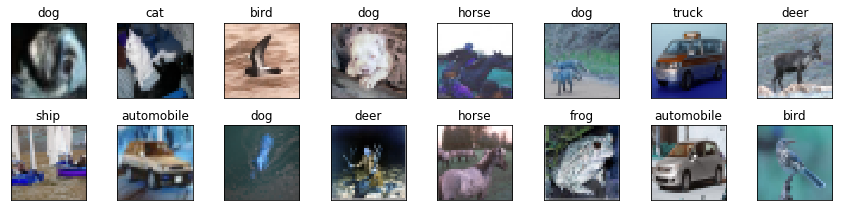

In [8]:
show_random_images(x_train, y_train, 2, 8)

In [9]:
x_train_hog = np.apply_along_axis(hog_feature, axis=1, arr=x_train)
x_test_hog = np.apply_along_axis(hog_feature, axis=1, arr=x_test)

In [10]:
print(x_train.shape, x_test.shape, len(y_train))
print(x_train_hog.shape, x_test_hog.shape, len(y_train))

(30000, 3072) (10000, 3072) 30000
(30000, 1296) (10000, 1296) 30000


In [17]:
scaler = StandardScaler()
x_train_hog_scaled = scaler.fit_transform(x_train_hog)
x_test_hog_scaled = scaler.transform(x_test_hog)

In [18]:
print(x_train_hog_scaled.shape, x_test_hog_scaled.shape, len(y_train))

(30000, 1296) (10000, 1296) 30000


In [9]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [10]:
print(x_train_scaled.shape, x_test_scaled.shape, len(y_train))

(30000, 3072) (10000, 3072) 30000


In [10]:
clf = LinearSVC()
model, train_acc, val_acc = train(x_train_hog, y_train, clf)

Train accuracy: 56.40%, validation acc: 42.82%


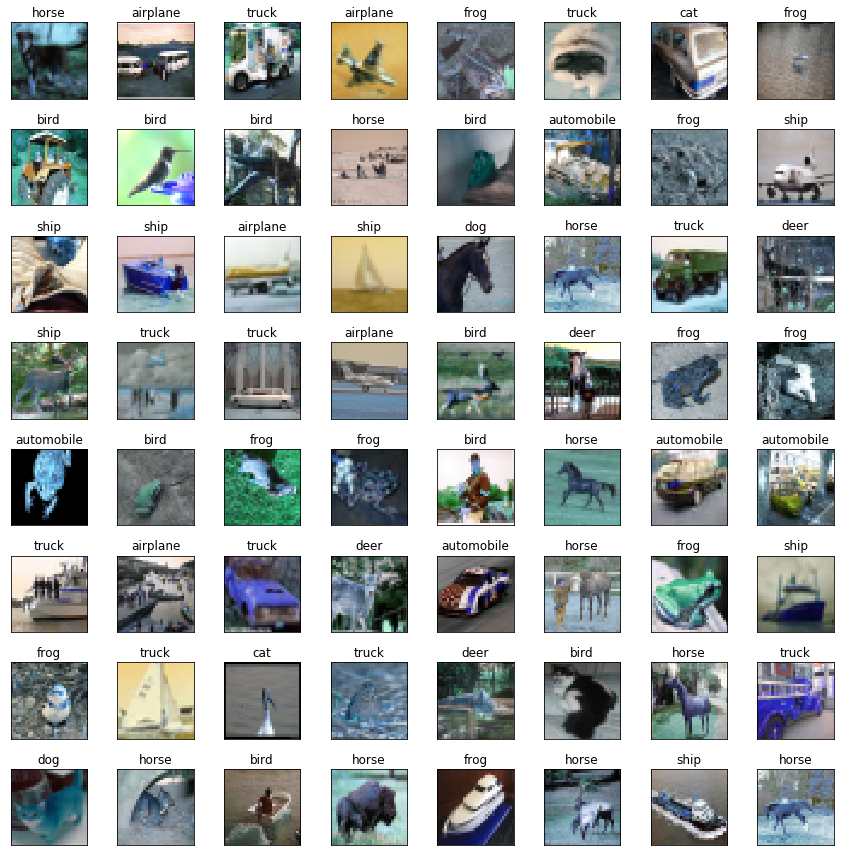

In [11]:
predict_random_images(x_test, x_test_hog, model, 8, 8)

In [34]:
test_pred = predict(model, x_test_hog, 'submissions/submission_2_%0.5f.csv' % val_acc)

In [11]:
# X_v1_train_hog = np.apply_along_axis(hog_feature, axis=1, arr=X_v1_train)
# X_v1_test_hog = np.apply_along_axis(hog_feature, axis=1, arr=X_v1_test)